# Import the YOLOv8 pretrained model

- The model is pretrained (in another notebook)  using a Roboflow dataset version on OM images. 

In [1]:
from ultralytics import YOLO
from matplotlib import pyplot as plt
from PIL import Image
PYTORCH_NO_CUDA_MEMORY_CACHING=1

from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import torch
from torch import cuda
import os
import numpy as np
import random
from PIL import Image
import matplotlib.colors as mcolors
import numpy.ma as ma
import json
np.set_printoptions(precision=15)

torch.backends.cudnn.deterministic = True
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from typing import Any, Dict, Generator, List
import matplotlib.pyplot as plt
import numpy as np

from importlib import reload
import dataset_utils, predictor_utils, loss#, data_mounting
reload(dataset_utils), reload(predictor_utils), reload(loss)#, reload(data_mounting)
from dataset_utils import *
from predictor_utils import *
from loss import *
# from data_mounting import *

import torch.autograd.profiler as profiler
device_id = 3
torch.cuda.set_device(device_id) # ❗️❗️❗️

In [2]:
use_wandb = False

if use_wandb:
    from datetime import datetime
    # !pip install wandb
    # !wandb login --relogin
    import wandb
    wandb.login()
    run = wandb.init(project="yolov8-segm-ft_no_stars-n", name=f"200_epochs-no_stars-n-SAM-fewer {datetime.now()}")

## Dataset (YOLOv8 format)

In [3]:
yolo_dataset_path = './xmm_om_images_512_SG_SR_CR_only-even_fewer/'

In [4]:
import yaml
with open(yolo_dataset_path+"data.yaml", 'r') as stream:
    yam_data = yaml.safe_load(stream) # dict with keys 'names', 'nc', 'roboflow', 'test', 'train', 'val'
yam_data['names']

classes = {i:name for i, name in enumerate(yam_data['names'])}
train_path = yam_data['train']
val_path = yam_data['val']
test_path = yam_data['test']
print(classes)

{0: 'central-ring', 1: 'cluster', 2: 'smoke-ring', 3: 'star-loop'}


In [5]:
# get masks from dataset (in YOLOv8 format) given an image file

def get_label_file_path(dataset_path, image_location):
    dataset_path = '/'.join(dataset_path.split('/')[:-2])+'/'+'labels'+'/'
    label_file_path = os.path.join(dataset_path, image_location)
    label_loc = '.'.join(image_location.split('.')[:-1]) + '.txt'
    label_file_path = dataset_path+label_loc
    return label_file_path

def read_annotations(label_file_path):
    annotations = []
    with open(label_file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            class_id = int(parts[0])
            segmentation_points = [float(p) for p in parts[1:]]
            annotations.append({
                'class_id': class_id,
                'segmentation_points': segmentation_points
            })
    return annotations

def get_masks_from_image(yolo_dataset_path, image_location):
    label_file_path = get_label_file_path(yolo_dataset_path, image_location)
    annotations = read_annotations(label_file_path)
    masks = [create_mask_0_1(annot['segmentation_points'], (512, 512)) for annot in annotations]
    return masks


**hyperparameters docs: https://docs.ultralytics.com/usage/cfg/#train**

In [6]:
def show_masks(masks, ax, random_color=False):
    for mask in masks:
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        else:
                color = np.array([30/255, 144/255, 255/255, 0.6])
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)

# Couple YOLO bboxes with SAM

In [7]:
def show_anns(anns):
    if len(anns) == 0:
        return
    ax = plt.gca()
    ax.set_autoscale_on(False)
    img = np.ones((anns.shape[1], anns.shape[2], 4))
    img[:,:,3] = 0
    for ann in range(anns.shape[0]):
        m = anns[ann].bool()
        m=m.cpu().numpy()
        color_mask = np.concatenate([np.random.random(3), [1]])
        img[m] = color_mask
    ax.imshow(img)

def batch_iterator(batch_size: int, *args) -> Generator[List[Any], None, None]:
    assert len(args) > 0 and all(
        len(a) == len(args[0]) for a in args
    ), "Batched iteration must have inputs of all the same size."
    n_batches = len(args[0]) // batch_size + int(len(args[0]) % batch_size != 0)
    for b in range(n_batches):
        yield [arg[b * batch_size : (b + 1) * batch_size] for arg in args]

**load SAM model**

In [8]:
import sys
import PIL
from PIL import Image

sys.path.append('/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/')
from ft_mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

mobile_sam_checkpoint = "/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/weights/mobile_sam.pt"
# mobile_sam_checkpoint = "./ft_mobile_sam_final.pth"

yolov8_pretrained_model = YOLO('./yolov8-segm-ft_no_stars-n/200_epochs-no_stars-n-even_fewer_obj25/weights/best.pt');
yolov8_pretrained_model.to(f'cuda:{device_id}');

device = f"cuda:{device_id}" if torch.cuda.is_available() else "cpu"
print("device:", device)

mobile_sam_model = sam_model_registry["vit_t"](checkpoint=mobile_sam_checkpoint)
mobile_sam_model.to(device)
predictor = SamPredictor(mobile_sam_model)

/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/ft_mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with ft_mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/ft_mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with ft_mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/ft_mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with ft_mobile_sam.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflicts with an existing na

device: cuda:3


In [9]:
train_dir = yolo_dataset_path+'train/images/'
valid_dir = yolo_dataset_path+'valid/images/'
train_image_files = os.listdir(train_dir)
valid_image_files = os.listdir(valid_dir)

In [10]:
for name, param in mobile_sam_model.named_parameters():
    params_to_train = ['mask_tokens', 'output_upscaling', 'output_hypernetworks_mlps', 'iou_prediction_head']
    if 'mask_decoder' in name: # and any(s in name for s in params_to_train):
    # if True:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [11]:
def check_requires_grad(model, show=True):
    for name, param in model.named_parameters():
        if param.requires_grad and show:
            print("✅ Param", name, " requires grad.")
        elif param.requires_grad == False:
            print("❌ Param", name, " doesn't require grad.")

print(f"🚀 The model has {sum(p.numel() for p in mobile_sam_model.parameters() if p.requires_grad)} trainable parameters.\n")
check_requires_grad(mobile_sam_model)

🚀 The model has 4058340 trainable parameters.

❌ Param image_encoder.patch_embed.seq.0.c.weight  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.0.bn.weight  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.0.bn.bias  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.2.c.weight  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.2.bn.weight  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.2.bn.bias  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv1.c.weight  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv1.bn.weight  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv1.bn.bias  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv2.c.weight  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv2.bn.weight  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv2.bn.bias  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv3.c.weigh

In [12]:
import time
import torch.nn.functional as F

import loss
reload(loss)
from loss import *
from importlib import reload
import astronomy_utils, predictor_utils, voc_annotate_and_Roboflow_export
reload(astronomy_utils)
reload(predictor_utils)
reload(voc_annotate_and_Roboflow_export)

from predictor_utils import *
from astronomy_utils import *
from voc_annotate_and_Roboflow_export import * 

import tqdm
from tqdm import tqdm

batch_size = 12
train_num_batches = len(train_image_files) // batch_size
valid_num_batches = len(valid_image_files) // batch_size

lr=6e-5
wd=0.00005
parameters_to_optimize = [param for param in mobile_sam_model.mask_decoder.parameters() if param.requires_grad]
optimizer = torch.optim.Adam(parameters_to_optimize, lr=lr, weight_decay=wd) #betas=(0.9, 0.999))

In [13]:
from torch.nn.functional import threshold, normalize

def run_epoch(phase, image_files, images_dir, num_batches, model_, optimizer=None, train_encoders=False):
    assert phase in ['train', 'val'], "Phase must be 'train' or 'val'"
    
    if phase == 'train':
        model_.train()  
    else:
        model_.eval() 

    epoch_sam_loss = []
    epoch_yolo_loss = []

    for batch_idx in tqdm(range(num_batches), desc=f"{phase.capitalize()} Batch"):
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size
        batch_files = image_files[start_idx:end_idx]

        batch_losses_sam = []
        batch_losses_yolo = []

        for image_name in batch_files:
            image_path = images_dir + image_name
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            obj_results = yolov8_pretrained_model.predict(image_path, verbose=False, conf=0.2) 
            if train_encoders:
                predictor.set_image(image)
            else:
                with torch.no_grad():
                    predictor.set_image(image)
            # sets a specific mean for each image
            # image_T = np.transpose(image, (2, 1, 0))
            # mean_ = np.mean(image_T[image_T>0])
            # std_ = np.std(image_T[image_T>0]) 
            # pixel_mean = torch.as_tensor([mean_, mean_, mean_], dtype=torch.float, device=device)
            # pixel_std = torch.as_tensor([std_, std_, std_], dtype=torch.float, device=device)
    
            # mobile_sam_model.register_buffer("pixel_mean", torch.Tensor(pixel_mean).unsqueeze(-1).unsqueeze(-1), False) # not in SAM
            # mobile_sam_model.register_buffer("pixel_std", torch.Tensor(pixel_std).unsqueeze(-1).unsqueeze(-1), False) # not in SAM
                
            gt_masks = get_masks_from_image(images_dir, image_name)  
            if len(obj_results[0]) == 0 or len(gt_masks) == 0:
                continue

            input_boxes1 = obj_results[0].boxes.xyxy
            expand_by = 2.5
            enlarged_bbox = input_boxes1.clone() 
            enlarged_bbox[:, :2] -= expand_by  
            enlarged_bbox[:, 2:] += expand_by  
            input_boxes1 = enlarged_bbox
            input_boxes = input_boxes1.cpu().numpy()
            input_boxes = predictor.transform.apply_boxes(input_boxes, predictor.original_size)
            input_boxes = torch.from_numpy(input_boxes).to(device)
            sam_mask, yolo_masks = [], []
            
            if train_encoders:
                image_embedding=predictor.features
                prompt_embedding=model_.prompt_encoder.get_dense_pe()
            else:
                with torch.no_grad():
                    image_embedding=predictor.features
                    prompt_embedding=model_.prompt_encoder.get_dense_pe()
                
            non_resized_masks = obj_results[0].masks.data.cpu().numpy()
            
            for i in range(len(non_resized_masks)):
                    yolo_masks.append(cv2.resize(non_resized_masks[i], image.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)) 

            for (boxes,) in batch_iterator(320, input_boxes): 
                if train_encoders:
                    sparse_embeddings, dense_embeddings = model_.prompt_encoder(
                        points=None,
                        boxes=boxes,
                        masks=None,)
                else:
                    with torch.no_grad():
                        sparse_embeddings, dense_embeddings = model_.prompt_encoder(
                            points=None,
                            boxes=boxes,
                            masks=None,)

                if phase == 'val':
                    with torch.no_grad():
                        low_res_masks, _ = model_.mask_decoder(
                            image_embeddings=image_embedding,
                            image_pe=prompt_embedding,
                            sparse_prompt_embeddings=sparse_embeddings,
                            dense_prompt_embeddings=dense_embeddings,
                            multimask_output=False,
                        )
                else:
                    low_res_masks, _ = model_.mask_decoder(
                            image_embeddings=image_embedding,
                            image_pe=prompt_embedding,
                            sparse_prompt_embeddings=sparse_embeddings,
                            dense_prompt_embeddings=dense_embeddings,
                            multimask_output=False,
                        )
                low_res_masks=predictor.model.postprocess_masks(low_res_masks, predictor.input_size, predictor.original_size)
                threshold_masks = torch.sigmoid(low_res_masks - model_.mask_threshold) 
                # threshold_masks = normalize(threshold(low_res_masks, 0.0, 0)).to(device)
                sam_mask_pre = (threshold_masks > 0.5)*1.0
                sam_mask.append(sam_mask_pre.squeeze(1))

                # reshape gt_masks to same shape as predicted masks
                gt_masks_tensor = torch.stack([torch.from_numpy(mask).unsqueeze(0) for mask in gt_masks], dim=0).to(device)
                yolo_masks_tensor = torch.stack([torch.from_numpy(mask).unsqueeze(0) for mask in yolo_masks], dim=0).to(device)
                segm_loss_sam = segm_loss_match_hungarian(threshold_masks, threshold_masks, gt_masks_tensor)
                segm_loss_yolo = segm_loss_match_hungarian(yolo_masks_tensor, threshold_masks, gt_masks_tensor)
                batch_losses_sam.append(segm_loss_sam)
                batch_losses_yolo.append(segm_loss_yolo)
                del sparse_embeddings, dense_embeddings, low_res_masks, gt_masks, 
                del yolo_masks_tensor, segm_loss_sam, segm_loss_yolo
                torch.cuda.empty_cache()

                # if phase == 'val':
                #     fig, axes = plt.subplots(1, 4, figsize=(18, 6)) 
                    
                #     # Plot 1: GT Masks
                #     axes[0].imshow(image)
                #     axes[0].set_title('GT Masks')
                #     show_masks(gt_masks_tensor.squeeze(1).squeeze(1).detach().cpu().numpy(), axes[0], random_color=True)
                    
                #     # Plot 2: YOLO Masks
                #     axes[1].imshow(image)
                #     axes[1].set_title('YOLOv8n predicted Masks')
                #     show_masks(yolo_masks, axes[1], random_color=True)
                    
                #     # Plot 3: Bounding Boxes
                #     image1 = cv2.resize(image, (1024, 1024))
                #     for bbox in boxes:
                #         x1, y1, x2, y2 = bbox.detach().cpu().numpy()
                #         x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                #         cv2.rectangle(image1, (x1, y1), (x2, y2), (0, 255, 0), 2) 
                #     image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
                #     axes[2].imshow(image1_rgb)
                #     axes[2].set_title('YOLOv8n predicted Bboxes')
                    
                #     # Plot 4: SAM Masks
                #     sam_masks_numpy = sam_mask[0].detach().cpu().numpy()
                #     axes[3].imshow(image)
                #     show_masks(sam_masks_numpy, axes[3], random_color=True)
                #     axes[3].set_title('MobileSAM predicted masks')
                #     plt.tight_layout() 
                #     # plt.savefig(f'./plots/combined_plots.png')
                #     plt.show()

        mean_loss_sam = torch.mean(torch.stack(batch_losses_sam)) * 1e5
        mean_loss_yolo = torch.mean(torch.stack(batch_losses_yolo))
        epoch_sam_loss.append(mean_loss_sam.item()/1e5)
        epoch_yolo_loss.append(mean_loss_yolo.item())

        if phase == 'train':
            optimizer.zero_grad()
            mean_loss_sam.backward()
            optimizer.step()

    print(f'Epoch {epoch}, {phase.capitalize()} Segmentation loss SAM: {np.mean(epoch_sam_loss)}. YOLO: {np.mean(epoch_yolo_loss)}')
    return np.mean(epoch_sam_loss), np.mean(epoch_yolo_loss), model_

In [14]:
best_valid_loss = float('inf')
num_epochs = 10
n_epochs_stop = 5 + num_epochs/10
epoch_sam_loss_train_list, epoch_sam_loss_val_list, epoch_yolo_loss_train_list, epoch_yolo_loss_val_list = [], [], [], []

model = mobile_sam_model
for epoch in range(num_epochs):
    epoch_sam_loss_train, epoch_yolo_loss_train, model = run_epoch('train', train_image_files, train_dir, train_num_batches, model, optimizer, train_encoders=True)
    epoch_sam_loss_val, epoch_yolo_loss_val, model = run_epoch('val', valid_image_files, valid_dir, valid_num_batches, model)

    epoch_sam_loss_train_list.append(epoch_sam_loss_train)
    epoch_sam_loss_val_list.append(epoch_sam_loss_val)
    epoch_yolo_loss_train_list.append(epoch_yolo_loss_train)
    epoch_yolo_loss_val_list.append(epoch_yolo_loss_val)
    
    if use_wandb:
        wandb.log({'epoch train SAM loss': epoch_sam_loss_train, 'epoch valid SAM loss': epoch_sam_loss_val})
        wandb.log({'epoch train YOLO loss': epoch_yolo_loss_train, 'epoch valid YOLO loss': epoch_yolo_loss_val})

    if epoch_sam_loss_val < best_valid_loss:
        best_valid_loss = epoch_sam_loss_val
        best_model = model
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print("Early stopping initiated.")
            early_stop = True
            break

torch.save(best_model.state_dict(), f'ft_mobile_sam_final.pth')
if use_wandb:
    run.finish()

Train Batch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:41<00:00,  1.61s/it]


Epoch 0, Train Segmentation loss SAM: 2.564356141826923. YOLO: 2.585478039888235


Val Batch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.01s/it]


Epoch 0, Val Segmentation loss SAM: 2.547908229166667. YOLO: 2.592063069343567


Train Batch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:40<00:00,  1.54s/it]


Epoch 1, Train Segmentation loss SAM: 2.542658461538461. YOLO: 2.584119274066045


Val Batch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.01s/it]


Epoch 1, Val Segmentation loss SAM: 2.5449545572916668. YOLO: 2.591546972592672


Train Batch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:42<00:00,  1.62s/it]


Epoch 2, Train Segmentation loss SAM: 2.5352293269230772. YOLO: 2.5829070072907667


Val Batch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.05s/it]


Epoch 2, Val Segmentation loss SAM: 2.5446841927083335. YOLO: 2.591144839922587


Train Batch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:40<00:00,  1.57s/it]


Epoch 3, Train Segmentation loss SAM: 2.531713828125. YOLO: 2.5820648670196533


Val Batch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.02s/it]


Epoch 3, Val Segmentation loss SAM: 2.542947005208333. YOLO: 2.5910284916559854


Train Batch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:40<00:00,  1.55s/it]


Epoch 4, Train Segmentation loss SAM: 2.528167295673077. YOLO: 2.5818070631760817


Val Batch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.00s/it]


Epoch 4, Val Segmentation loss SAM: 2.542765885416667. YOLO: 2.591064174969991


Train Batch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:40<00:00,  1.56s/it]


Epoch 5, Train Segmentation loss SAM: 2.5224041045673076. YOLO: 2.581647414427537


Val Batch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.02s/it]


Epoch 5, Val Segmentation loss SAM: 2.542312578125. YOLO: 2.59144119421641


Train Batch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:40<00:00,  1.57s/it]


Epoch 6, Train Segmentation loss SAM: 2.5197813401442306. YOLO: 2.5817852937258206


Val Batch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.00s/it]


Epoch 6, Val Segmentation loss SAM: 2.5427835416666666. YOLO: 2.5913987954457602


Train Batch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:39<00:00,  1.53s/it]


Epoch 7, Train Segmentation loss SAM: 2.51997828125. YOLO: 2.5815305618139415


Val Batch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.02s/it]


Epoch 7, Val Segmentation loss SAM: 2.5481919791666665. YOLO: 2.5923531452814736


Train Batch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:40<00:00,  1.56s/it]


Epoch 8, Train Segmentation loss SAM: 2.518357181490385. YOLO: 2.5825110032008243


Val Batch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.01s/it]


Epoch 8, Val Segmentation loss SAM: 2.543447942708333. YOLO: 2.5918562412261963


Train Batch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:41<00:00,  1.61s/it]


Epoch 9, Train Segmentation loss SAM: 2.517565252403846. YOLO: 2.581353499339177


Val Batch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.01it/s]

Epoch 9, Val Segmentation loss SAM: 2.547555286458333. YOLO: 2.5922401746114097


In [15]:
len(train_image_files), len(valid_image_files)

(312, 79)

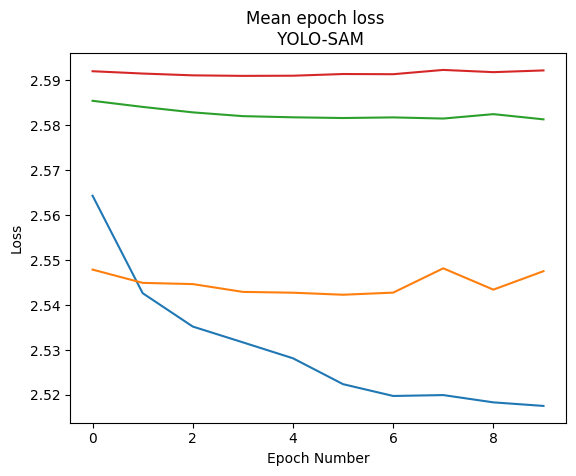

In [16]:
plt.plot(list(range(len(epoch_sam_loss_train_list))), epoch_sam_loss_train_list)
plt.plot(list(range(len(epoch_sam_loss_val_list))), epoch_sam_loss_val_list)
plt.plot(list(range(len(epoch_yolo_loss_train_list))), epoch_yolo_loss_train_list)
plt.plot(list(range(len(epoch_yolo_loss_val_list))), epoch_yolo_loss_val_list)

plt.title('Mean epoch loss \n YOLO-SAM')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.savefig('loss_yolo_SAM.png')
plt.show()
plt.close()

In [17]:
import glob
from roboflow import Roboflow

def export_image_det_to_Roboflow(input_dir, filename, masks, obj_results):
    class_names = obj_results[0].names
    class_labels = obj_results[0].boxes.data[:, -1].int().tolist()
    
    objects = []
    for i in range(len(masks)):
        # masks[i]: [ 1, H, W]
        mask_np = masks[i].detach().cpu().numpy()
        polygon = binary_image_to_polygon(mask_np[0])
        bbox = mask_to_bbox(mask_np)
        if class_names[class_labels[i]] != 'star' and class_names[class_labels[i]] != 'other': # ignore stars and 'other' label
            objects.append({
                'name': class_names[class_labels[i]],
                'bbox': bbox,
                'segmentations': polygon[0]
            })
    if len(objects)>0:
        create_annotation_SAM(filename=filename, width=512, height=512, depth=3, objects=objects) # generating xml file for VOC format
        image_path = input_dir+filename
        annotation_filename = filename.replace(".png", ".xml")
        upload_project.upload(image_path, annotation_filename, overwrite=False)
        os.remove(annotation_filename)
    else:
        print("No objects after label filtering.")

loading Roboflow workspace...
loading Roboflow project...
Image ../XMM_OM_dataset/zscaled_512_stretched/S0059752301_B.png
Inference time per image: 0.9182543754577637


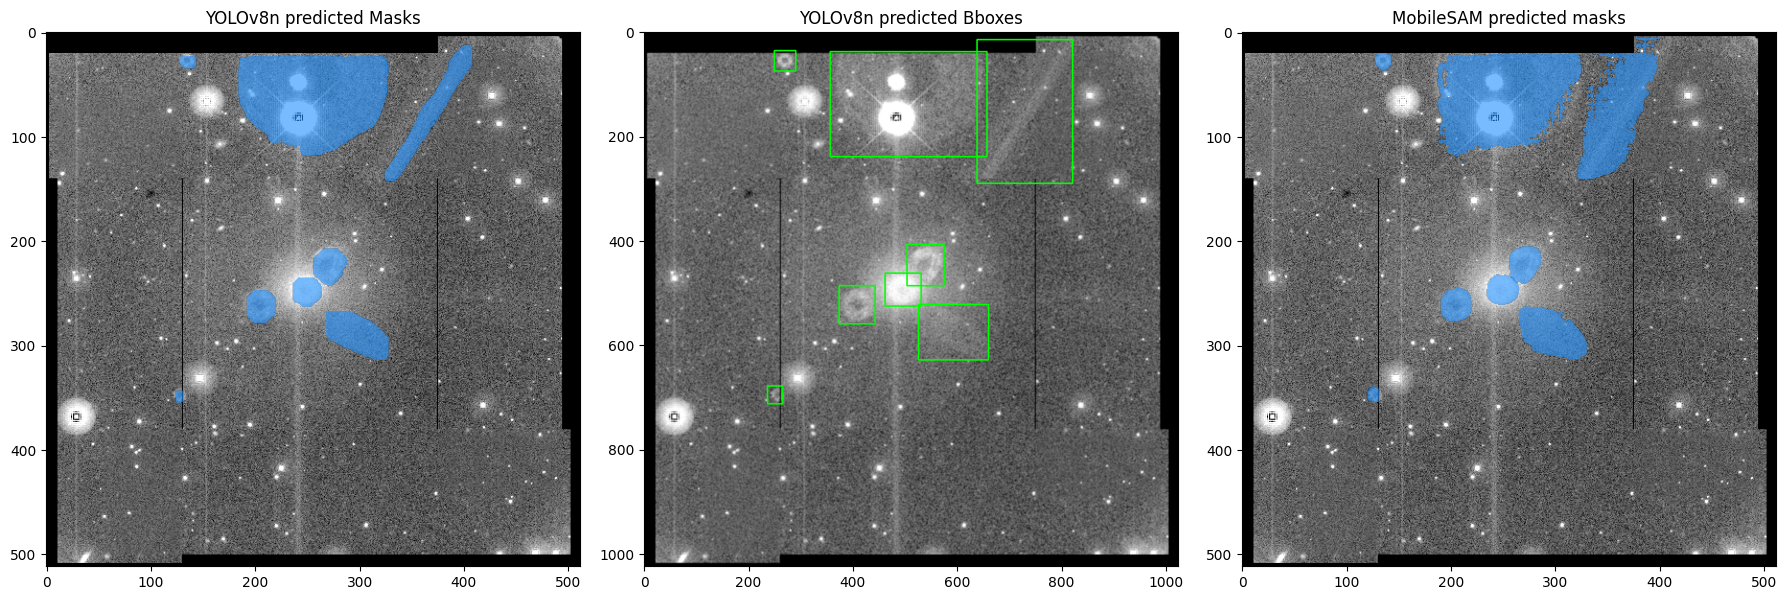

In [18]:
# Optional Roboflow export in VOC format given filenames
export_to_Roboflow = True
import time

best_model = mobile_sam_model.cpu()
if export_to_Roboflow:
    # Initialize Roboflow client
    rf = Roboflow(api_key="EBeK30tpU3HW2VGGl0xa")
    upload_project = rf.workspace("orij").project("xmm_om_images_512_sg_sr_cr_only") # error if the project doesn't exist

    new_images_dir = '../XMM_OM_dataset/zscaled_512_stretched/'
    new_image_files =  os.listdir(new_images_dir)
    best_model.eval()
    
    with torch.no_grad(): 
        # eg_img = 'S0018141301_M.png'
        for eg_img in new_image_files[701:702]:
        # if True:
                print('Image', new_images_dir+eg_img)
                image = cv2.imread(new_images_dir + eg_img)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                start_time = time.time()
                obj_results = yolov8_pretrained_model.predict(new_images_dir + eg_img, conf=0.2)  
                predictor.set_image(image)
            
                if len(obj_results[0]) == 0:
                    print(f"No masks for {image_name}.")
                    plt.imshow(image)
                    plt.show()
                    plt.close()
                    # continue
        
                input_boxes1 = obj_results[0].boxes.xyxy
                expand_by = 2.5
                enlarged_bbox = input_boxes1.clone() 
                enlarged_bbox[:, :2] -= expand_by  
                enlarged_bbox[:, 2:] += expand_by  
                input_boxes1 = enlarged_bbox
        
                input_boxes = input_boxes1.cpu().numpy()
                input_boxes = predictor.transform.apply_boxes(input_boxes, predictor.original_size)
                input_boxes = torch.from_numpy(input_boxes).to(device)
                sam_mask, yolo_masks = [], []
                image_embedding=predictor.features
                prompt_embedding=best_model.prompt_encoder.get_dense_pe()
                non_resized_masks = obj_results[0].masks.data.cpu().numpy()
                for i in range(len(non_resized_masks)):
                        yolo_masks.append(cv2.resize(non_resized_masks[i], image.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)) 
            
                for (boxes,) in batch_iterator(320, input_boxes): 
                    with torch.no_grad():
                        image_embedding=image_embedding[0:boxes.shape[0],:,:,:]
                        prompt_embedding=prompt_embedding[0:boxes.shape[0],:,:,:]
                        sparse_embeddings, dense_embeddings = best_model.prompt_encoder(
                            points=None,
                            boxes=boxes.cpu(),
                            masks=None,)
                        low_res_masks, _ = best_model.mask_decoder(
                            image_embeddings=image_embedding,
                            image_pe=prompt_embedding,
                            sparse_prompt_embeddings=sparse_embeddings,
                            dense_prompt_embeddings=dense_embeddings,
                            multimask_output=False,
                        )
                        low_res_masks=predictor.model.postprocess_masks(low_res_masks, predictor.input_size, predictor.original_size)
                        threshold_masks = torch.sigmoid(low_res_masks - best_model.mask_threshold) 
                        sam_mask_pre = (threshold_masks > 0.5)*1.0
                        sam_mask.append(sam_mask_pre.squeeze(1))
        
                        yolo_masks_tensor = torch.stack([torch.from_numpy(mask).unsqueeze(0) for mask in yolo_masks], dim=0)
                        # export_image_det_to_Roboflow(new_images_dir, image_name, sam_mask_pre, obj_results)
                        print("Inference time per image:", time.time()-start_time)
                        fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 
                        
                        # Plot 1: YOLO Masks
                        axes[0].imshow(image)
                        axes[0].set_title('YOLOv8n predicted Masks')
                        show_masks(yolo_masks, axes[0]) #, random_color=True)
                        
                        # Plot 2: Bounding Boxes
                        image1 = cv2.resize(image, (1024, 1024))
                        for bbox in boxes:
                            x1, y1, x2, y2 = bbox.detach().cpu().numpy()
                            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                            cv2.rectangle(image1, (x1, y1), (x2, y2), (0, 255, 0), 2) 
                        image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
                        axes[1].imshow(image1_rgb)
                        axes[1].set_title('YOLOv8n predicted Bboxes')
                        
                        # Plot 3: SAM Masks
                        sam_masks_numpy = sam_mask[0].detach().cpu().numpy()
                        axes[2].imshow(image)
                        show_masks(sam_masks_numpy, axes[2]) #, random_color=True)
                        axes[2].set_title('MobileSAM predicted masks')
                        plt.tight_layout() 
                        # plt.savefig(f'./plots/combined_plots.png')
                        plt.show()

In [19]:
# yolov8_pretrained_model.export(format='onnx', imgsz=[512,512])

In [20]:
# import torch
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# sys.path.append('/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/')

# from importlib import reload
# from ft_mobile_sam import sam_model_registry, SamPredictor
# from ft_mobile_sam.utils.onnx import SamOnnxModel

# import onnxruntime
# from onnxruntime.quantization import QuantType
# from onnxruntime.quantization.quantize import quantize_dynamic

# import warnings
# onnx_model_path = None  # Set to use an already exported model, then skip to the next section.

# onnx_model_path = "sam_onnx_example.onnx"

# sam = mobile_sam_model.to('cpu') # the model must be set on CP
# onnx_model = SamOnnxModel(sam, return_single_mask=True)

# dynamic_axes = {
#     "point_coords": {1: "num_points"},
#     "point_labels": {1: "num_points"},
# }

# embed_dim = sam.prompt_encoder.embed_dim
# embed_size = sam.prompt_encoder.image_embedding_size
# mask_input_size = [4 * x for x in embed_size]
# dummy_inputs = {
#     "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
#     "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
#     "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
#     "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
#     "has_mask_input": torch.tensor([1], dtype=torch.float),
#     # "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
# }
# output_names = ["masks", "iou_predictions", "low_res_masks"]

# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
#     warnings.filterwarnings("ignore", category=UserWarning)
#     with open(onnx_model_path, "wb") as f:
#         torch.onnx.export(
#             onnx_model,
#             tuple(dummy_inputs.values()),
#             f,
#             export_params=True,
#             verbose=False,
#             opset_version=16,
#             do_constant_folding=True,
#             input_names=list(dummy_inputs.keys()),
#             output_names=output_names,
#             dynamic_axes=dynamic_axes,
#         )    

In [21]:
# optional: export to ONNX

# !python scripts/export_onnx_model.py --checkpoint ./weights/mobile_sam.pt --model-type vit_t --output ./mobile_sam.onnx